In [1]:
import keras
import tensorflow as tf

In [2]:
print(keras.__version__)

2.7.0


In [3]:
from __future__ import print_function

from keras.layers import Input, Dense, Lambda, Reshape
from keras.models import Model
from keras import backend as K
from keras import metrics

In [4]:
import numpy as np

from keras.datasets import mnist
from keras.utils.vis_utils import plot_model

In [5]:
import matplotlib.pyplot as plt
from scipy.stats import norm

In [6]:
from tensorflow.python.framework.ops import disable_eager_execution

# needed for custom loss
disable_eager_execution()

In [7]:
# x, z size 
original_dim = 28 * 28

In [8]:
# hyper params
batch_size = 128
latent_dim = 2
intermediate_dim = 256
epochs = 120
epsilon_std = 1.0

In [9]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [10]:
x_train.shape

(60000, 784)

In [11]:
def sampling(args: tuple):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [12]:
# encoder
x = Input(shape=(original_dim,), name="input")
h = Dense(intermediate_dim, activation='relu', name="encoding")(x)
z_mean = Dense(latent_dim, name="mean")(h)
# defining the log variance of the latent space
z_log_var = Dense(latent_dim, name="log-variance")(h)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])


In [13]:
encoder = Model(x, [z_mean, z_log_var, z], name="encoder")
# print out summary of what we just did
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 784)]        0           []                               
                                                                                                  
 encoding (Dense)               (None, 256)          200960      ['input[0][0]']                  
                                                                                                  
 mean (Dense)                   (None, 2)            514         ['encoding[0][0]']               
                                                                                                  
 log-variance (Dense)           (None, 2)            514         ['encoding[0][0]']               
                                                                                            

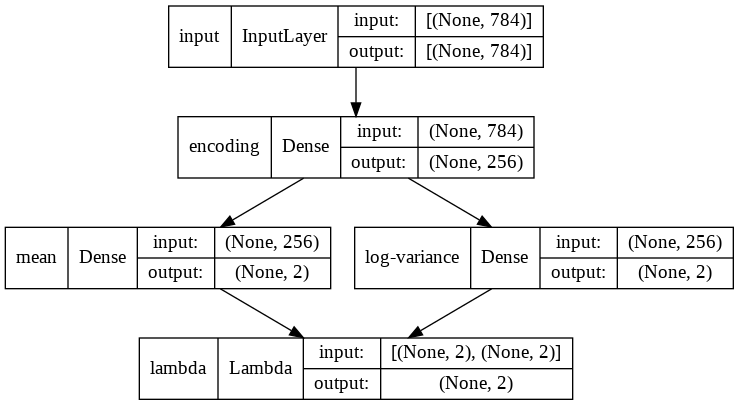

In [14]:
plot_model(encoder, to_file='encoder.png', show_shapes=True, show_layer_names=True)

In [15]:
# decoder
input_decoder = Input(shape=(latent_dim,), name="dec_input")
decoder_h = Dense(intermediate_dim, activation='relu', name="dec_h")(input_decoder)
x_decoded = Dense(original_dim, activation='sigmoid', name="dec_flat")(decoder_h)

In [16]:
decoder = Model(input_decoder, x_decoded, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dec_input (InputLayer)      [(None, 2)]               0         
                                                                 
 dec_h (Dense)               (None, 256)               768       
                                                                 
 dec_flat (Dense)            (None, 784)               201488    
                                                                 
Total params: 202,256
Trainable params: 202,256
Non-trainable params: 0
_________________________________________________________________


In [17]:
# link the input and the overall output
vae = Model(x, decoder(encoder(x)[2]))
vae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 2),               201988    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 784)               202256    
                                                                 
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


In [18]:
# custom KL loss
def vae_loss(x: tf.Tensor,
             x_decoded_mean: tf.Tensor,
             z_log_var=z_log_var,
             z_mean=z_mean,
            original_dim=original_dim):
    xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(
        1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)
    return vae_loss

In [19]:
vae.compile(optimizer='rmsprop', loss=vae_loss, experimental_run_tf_function=False)

In [23]:
history = vae.fit(x_train, x_train,
                  shuffle=True,
                  epochs=epochs,
                  batch_size=batch_size,
                  verbose=0) # silent output

In [29]:
print('Final Loss: ', history.history['loss'])

Final Loss:  [146.3966098795573]


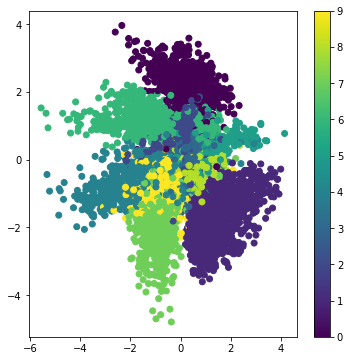

In [30]:
# latent space of the digit classes
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)[0]
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test, cmap='viridis')
plt.colorbar()
plt.show()

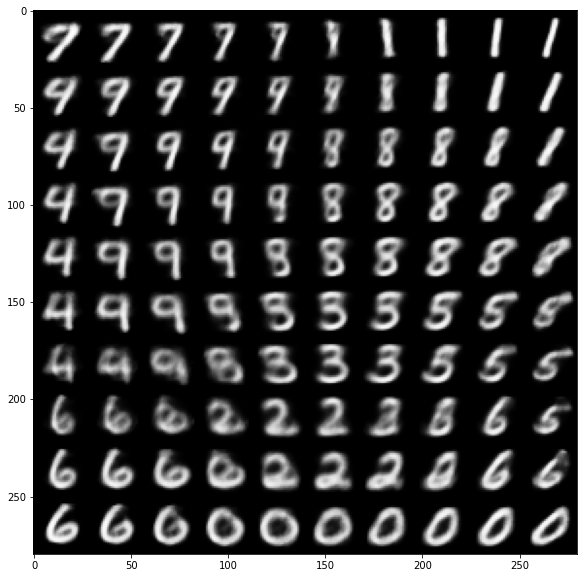

In [31]:
# display digit generation
n = 10  # figure with n x n digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()